# Initial reasoning

- Friedman and Nemenyi Tests → These tests require balanced data (same number of trials per dataset/framework), which isn't the case here.
- Wilcoxon Signed-Rank Test → Requires paired observations, which doesn't work well for unbalanced trial counts.

In [1]:
# !pip install cliffs-delta

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import scikit_posthocs as sp
from cliffs_delta import cliffs_delta  # Cliff’s Delta for effect size correction
from statsmodels.stats.multitest import multipletests  # Multiple comparison correction

# Load Data produced by utils_stats_review_data.ipynb
scenario = 'binary'
df = pd.read_csv(f"stats/{scenario}/f1_scores_results.csv")
df.dropna(subset=["F1 Score"], inplace=True)  # Remove missing values

# Compute Median F1-score for Each Framework
framework_medians = df.groupby("Framework")["F1 Score"].median().sort_values(ascending=False)

# 1a. Mann-Whitney U Test (Pairwise Comparison)

### This section performs a pairwise statistical significance test between all AutoML frameworks using the Mann-Whitney U test.
- The test determines whether one framework has significantly higher F1 scores than another.
- The results include p-values, which indicate whether the differences are statistically significant.

# 1b. Effect Sizes (Cliff's Delta) and Practical Significance

### This section computes effect sizes using Cliff’s Delta for each framework comparison.

- Cliff’s Delta measures how much one framework outperforms another in terms of F1 score.
- Unlike p-values, which only indicate significance, effect size quantifies the magnitude of the difference.
- Interpretation of values:
  - Positive values → "Framework 1" performs better than "Framework 2".
  - Negative values → "Framework 2" performs better than "Framework 1".
  - Closer to 0 → No practical difference.

# 1c. Multiple Comparisons Correction (Bonferroni)
- Since multiple pairwise comparisons are made, the Bonferroni correction is applied to adjust p-values and reduce the risk of false positives.
- A result is considered statistically significant only if the adjusted p-value < 0.05.

# 1d. Output

### The results are saved in mannwhitney_df, which contains:
- "Framework 1", "Framework 2" → Compared frameworks.
- "p-value", "Adjusted p-value" → Significance levels before and after Bonferroni correction.
- "Effect Size", "Magnitude" → Practical significance of differences.
- "Significant" → Boolean flag indicating if the difference is statistically significant.

In [3]:
import pandas as pd
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

frameworks = df["Framework"].unique()
mannwhitney_results = []

for i in range(len(frameworks)):
    for j in range(i + 1, len(frameworks)):
        fw1, fw2 = frameworks[i], frameworks[j]

        scores_fw1 = df[df["Framework"] == fw1]["F1 Score"].dropna()
        scores_fw2 = df[df["Framework"] == fw2]["F1 Score"].dropna()

        if len(scores_fw1) > 1 and len(scores_fw2) > 1:
            # Perform Mann-Whitney U test
            stat, p = mannwhitneyu(scores_fw1, scores_fw2, alternative="two-sided")

            # Compute effect size (Cliff’s Delta)
            delta, magnitude = cliffs_delta(scores_fw1.tolist(), scores_fw2.tolist())

            # Append all results at once
            mannwhitney_results.append((fw1, fw2, p, delta, magnitude))

# Convert results to DataFrame
mannwhitney_df = pd.DataFrame(mannwhitney_results, columns=["Framework 1", "Framework 2", "p-value", "Effect Size", "Magnitude"])

# Apply Bonferroni Correction for Multiple Comparisons
p_corrected = multipletests(mannwhitney_df["p-value"], method="bonferroni")[1]
mannwhitney_df["Adjusted p-value"] = p_corrected
mannwhitney_df["Significant"] = mannwhitney_df["Adjusted p-value"] < 0.05  # Mark significant comparisons

# Reorder columns
desired_column_order = ["Framework 1", "Framework 2", "p-value", "Adjusted p-value", "Significant", "Effect Size", "Magnitude"]
mannwhitney_df = mannwhitney_df[desired_column_order]

# Save results
mannwhitney_df.to_csv(f'stats/{scenario}/step_1_mannwhitney.csv', index=False)

mannwhitney_df

,Framework 1,Framework 2,p-value,Adjusted p-value,Significant,Effect Size,Magnitude
0,4intelligence,autogluon,0.530715,1.000000,False,-0.043367,negligible
1,4intelligence,autokeras,0.940482,1.000000,False,0.005204,negligible
2,4intelligence,autopytorch,0.879606,1.000000,False,0.010510,negligible
3,4intelligence,autosklearn,0.000634,0.076093,False,-0.235000,small
4,4intelligence,evalml,0.998055,1.000000,False,0.000232,negligible
...,...,...,...,...,...,...,...
115,mljar,pycaret,0.022094,1.000000,False,-0.158214,small
116,mljar,tpot,0.014059,1.000000,False,-0.177900,small
117,naive,pycaret,0.445162,1.000000,False,0.071841,negligible
118,naive,tpot,0.993193,1.000000,False,0.000986,negligible


# 2. Statistical Ranking of AutoML Frameworks

### This part performs statistical ranking of AutoML frameworks based on statistical significance (Wins), effect size, and magnitude from Mann-Whitney U tests.

In [4]:
# Compute Wins directly from mannwhitney_df
wins = mannwhitney_df[mannwhitney_df["Effect Size"] > 0].groupby("Framework 1")["Significant"].sum().reset_index()
wins.columns = ["Framework 1", "Wins"]

# Merge Wins with Effect Size and Magnitude
final_ranking = wins.merge(
    mannwhitney_df.groupby("Framework 1").agg({"Effect Size": "mean", "Magnitude": lambda x: x.mode()[0]}).reset_index(),
    on="Framework 1",
    how="left"
)

# Sort by Wins and Effect Size (descending)
final_ranking = final_ranking.sort_values(by=["Wins", "Effect Size"], ascending=[False, False])

# Save the final ranking
final_ranking.to_csv(f"stats/{scenario}/step_2_final_ranking.csv", index=False)

# Display the sorted final ranking
final_ranking

,Framework 1,Wins,Effect Size,Magnitude
4,autosklearn,5,0.265579,small
8,gama,3,0.306220,negligible
6,fedot,2,0.140158,negligible
1,autogluon,2,0.077483,negligible
3,autopytorch,2,0.043047,negligible
0,4intelligence,2,0.011192,negligible
5,evalml,2,-0.065783,medium
7,flaml,1,0.008804,small
2,autokeras,1,-0.077085,small
9,h2o,1,-0.241367,large


### Statistical Significance (p-value from Mann-Whitney U test)
- "Wins" count how many times the framework significantly outperforms another.
- "Significant" (from mannwhitney_df) ensures adjusted p-values < 0.05.

### Practical Significance (Effect Size – Cliff’s Delta)
- "Effect Size" > 0 means the framework has a meaningful performance difference.
- "Magnitude" helps interpret whether the difference is small, medium, or large.

In [5]:
print("\nEvaluating the best framework based on Wins, Effect Size, and Magnitude...")

# Ensure final_ranking is not empty before proceeding
if not final_ranking.empty and "Effect Size" in final_ranking.columns:

    # Filter frameworks with positive effect size
    positive_effects = final_ranking[final_ranking["Effect Size"] > 0]

    if not positive_effects.empty:
        print("Found frameworks with positive Effect Sizes. Ranking by Wins and Effect Size...")

        # Rank frameworks: highest Wins, then highest Effect Size
        best_framework_row = positive_effects.sort_values(by=["Wins", "Effect Size"], ascending=[False, False]).iloc[0]

        reason = "This framework has the highest number of Wins and a positive Effect Size, making it both statistically and practically significant."
    else:
        print("No frameworks have a positive Effect Size. Selecting based on highest Wins...")

        # If all effect sizes are negative, use the highest Wins framework
        best_framework_row = final_ranking.iloc[0]

        reason = "All effect sizes are negative, meaning no framework showed a strong practical advantage. The framework with the highest Wins is selected as the best option."

    best_framework = best_framework_row["Framework 1"]

    # Print details of the selected framework
    print(f"\nRecommended Framework: {best_framework}")
    print(f"\tWins: {best_framework_row['Wins']}")
    print(f"\tEffect Size: {best_framework_row['Effect Size']:.4f}")
    print(f"\tMagnitude: {best_framework_row['Magnitude']}")
    print(f"\tReason: {reason}")

else:
    best_framework = "No significant winner"
    print("\nNo significant differences were found in the results. No framework is recommended.")


Evaluating the best framework based on Wins, Effect Size, and Magnitude...
Found frameworks with positive Effect Sizes. Ranking by Wins and Effect Size...

Recommended Framework: autosklearn
	Wins: 5
	Effect Size: 0.2656
	Magnitude: small
	Reason: This framework has the highest number of Wins and a positive Effect Size, making it both statistically and practically significant.


# 3. Boxplot of F1 Scores per Framework

### Each boxplot visualizes the F1-score distribution for a framework:
- Median (middle line in the box) → Represents central tendency.
- Interquartile Range (IQR) (box size) → Shows spread of middle 50% of scores.
- Whiskers (lines extending from the box) → Represent data variability (excluding outliers).
- Outliers (dots outside the whiskers) → Show extreme performance variations.

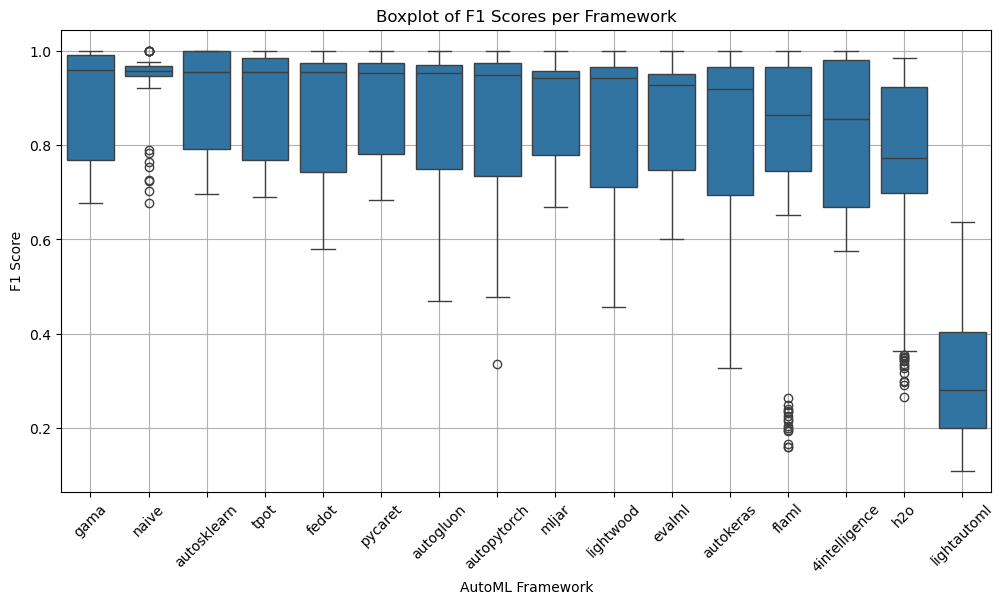

In [6]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="Framework", y="F1 Score", data=df, order=framework_medians.index)
plt.xticks(rotation=45)
plt.title("Boxplot of F1 Scores per Framework")
plt.xlabel("AutoML Framework")
plt.ylabel("F1 Score")
plt.grid()
plt.savefig(f'stats/{scenario}/step_3_box_plot.png', dpi=300)
plt.show()

# 4. Violin Plot for Framework Distributions

### A violin plot is a combination of a boxplot and a density plot:
- Shape & Width → Indicates data distribution (wider parts show where most values are concentrated).
- Inner Boxplot → Shows median and interquartile range (IQR).
- Whiskers → Represent data variability.

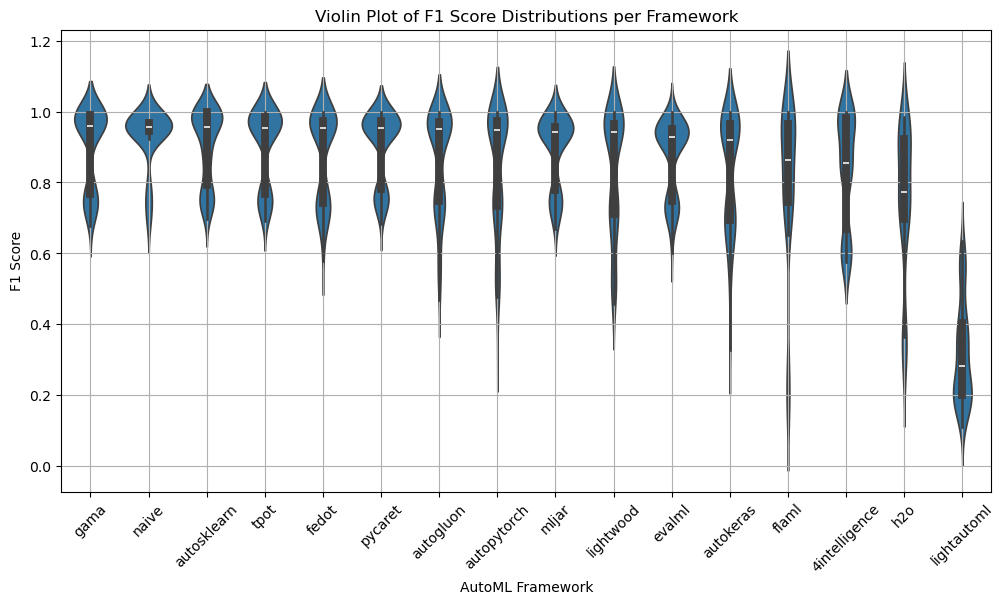

In [7]:
plt.figure(figsize=(12, 6))
sns.violinplot(x="Framework", y="F1 Score", data=df, order=framework_medians.index)
plt.xticks(rotation=45)
plt.title("Violin Plot of F1 Score Distributions per Framework")
plt.xlabel("AutoML Framework")
plt.ylabel("F1 Score")
plt.grid()
plt.savefig(f'stats/{scenario}/step_4_violin_plot.png', dpi=300)
plt.show()

# 5. Violin / Swarm Plot Overlay for Framework Distributions

### Each framework’s F1 scores are displayed as individual points:
- Denser areas indicate more trials with similar F1 scores.
- Widely scattered points suggest high variance.
- Clusters or gaps can indicate inconsistencies in model performance.

### Considerations:
- Prevents Overlapping Points → Uses a smart algorithm to position points so they do not overlap.
- Better for Small Datasets → Clearly shows individual distributions without hiding points.
- Downside: If too many points exist, some cannot be placed, leading to warnings.

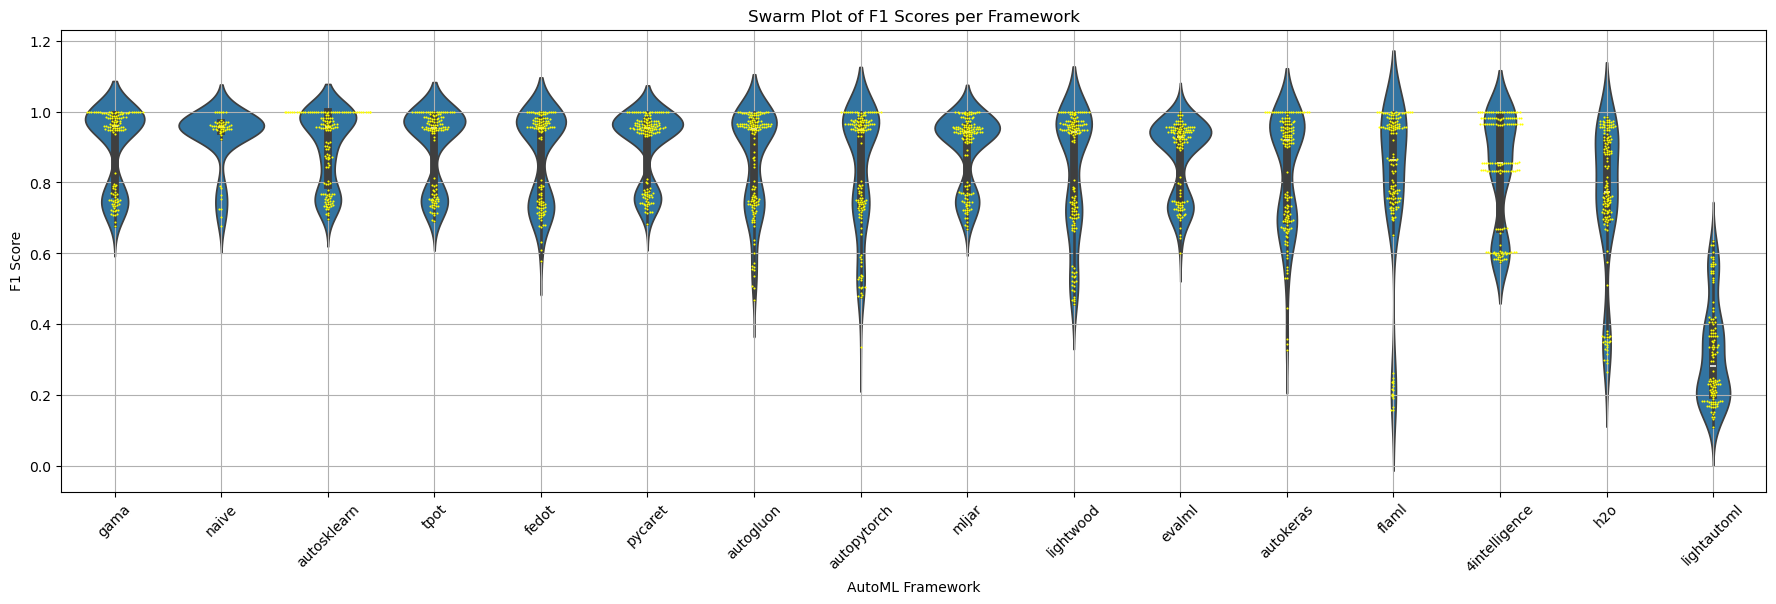

In [8]:
plt.figure(figsize=(22, 6))
sns.violinplot(x="Framework", y="F1 Score", data=df, order=framework_medians.index)
sns.swarmplot(x="Framework", y="F1 Score", data=df, order=framework_medians.index, color="yellow", size=1.5)
plt.xticks(rotation=45)
plt.title("Swarm Plot of F1 Scores per Framework")
plt.xlabel("AutoML Framework")
plt.ylabel("F1 Score")
plt.grid()
plt.savefig(f'stats/{scenario}/step_5_swarm_plot.png', dpi=300)
plt.show()

# 6. Violin / Strip Plot Overlay for Framework Distributions

### Each framework’s F1 scores are displayed as individual points:
- Denser areas indicate more trials with similar F1 scores.
- Widely scattered points suggest high variance.
- Clusters or gaps can indicate inconsistencies in model performance.

### Considerations:
- Allows Overlapping Points → Uses jitter (random small shifts) to avoid complete overlap.
- Better for Large Datasets → Works well when there are many points in the same position.
- Downside: Can create clusters of overlapping points, making density harder to interpret.

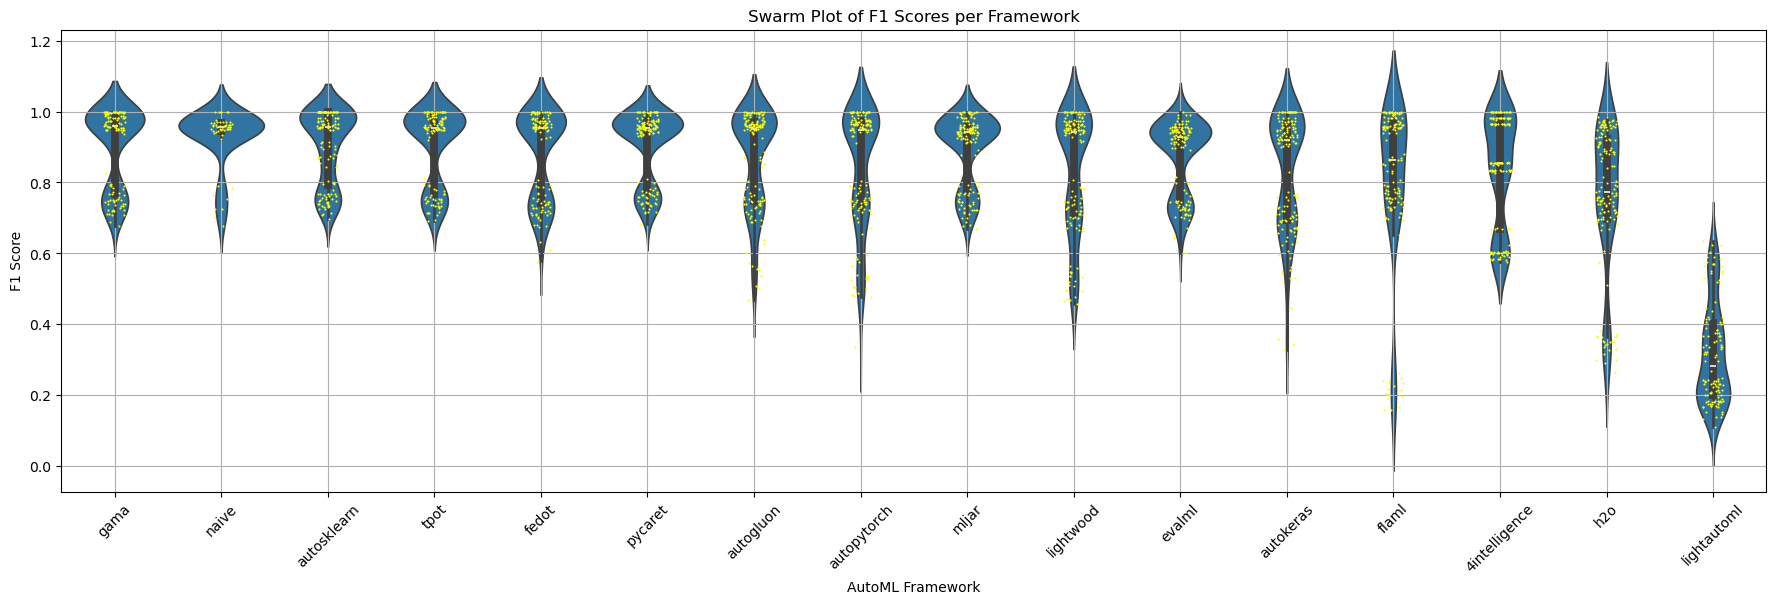

In [9]:
plt.figure(figsize=(22, 6))
sns.violinplot(x="Framework", y="F1 Score", data=df, order=framework_medians.index)
sns.stripplot(x="Framework", y="F1 Score", data=df, order=framework_medians.index, color="yellow", size=1.5)
plt.xticks(rotation=45)
plt.title("Swarm Plot of F1 Scores per Framework")
plt.xlabel("AutoML Framework")
plt.ylabel("F1 Score")
plt.grid()
plt.savefig(f'stats/{scenario}/step_6_strip_plot.png', dpi=300)
plt.show()

# 7. Heatmap of Significance (Bonferroni-corrected p-values)

### This part creates a heatmap of the Bonferroni-corrected p-values from the Mann-Whitney U test, visualizing the statistical significance of differences between frameworks.
- Cells with p-values < 0.05 → Statistically significant differences (frameworks perform differently).
- Cells with p-values > 0.05 → No significant difference (frameworks perform similarly).
- Diagonal cells (fw1 == fw2) → Always 1.0 (self-comparisons).

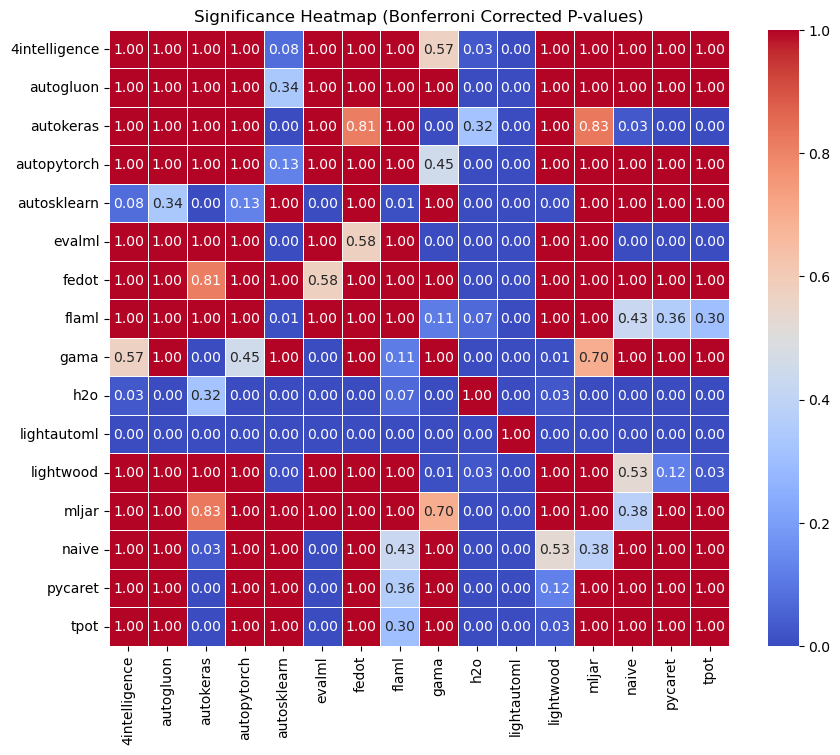

In [10]:
# Ensure all frameworks are included
frameworks_list = sorted(set(df["Framework"].unique()) | set(mannwhitney_df["Framework 1"]) | set(mannwhitney_df["Framework 2"]))

# Initialize p-value matrix with NaNs (indicating "not tested" by default)
p_matrix = pd.DataFrame(np.nan, index=frameworks_list, columns=frameworks_list)

# Set diagonal (self-comparisons) to 1.0
np.fill_diagonal(p_matrix.values, 1.0)

# Populate matrix with Bonferroni-corrected p-values
for fw1, fw2, p in zip(mannwhitney_df["Framework 1"], mannwhitney_df["Framework 2"], mannwhitney_df["Adjusted p-value"]):
    p_matrix.loc[fw1, fw2] = p
    p_matrix.loc[fw2, fw1] = p  # Ensure symmetry

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(p_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, mask=p_matrix.isna())
plt.title("Significance Heatmap (Bonferroni Corrected P-values)")
plt.savefig(f'stats/{scenario}/step_7_significance_heatmap.png', dpi=300)
plt.show()